In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils as utils

import os 
import numpy as np 
import pandas as pd 
import random 
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
os.chdir("dataset")
files = os.listdir()

In [37]:
traindata = dict()
validdata = dict()
for sc, file in enumerate(files):
    shape = 1 if "SQUARE" in file else 0
    dataset = pd.read_csv(file).values
    c = 0
    for data in dataset:
        if len(str(data[0]).split(" ")) >= 6:
            data = [d for d in  data[0].split(" ") if d != ""]
            height =  50 + (10 * (c // 1000))
            frequency = c % 1000 + 1
            c = c + 1
            for n, d in enumerate(data):
                    temperature = 300 + n * 100
                    X = tuple([shape, temperature, frequency, height])
                    try:
                        if d[-1] == "i":

                            d = float(str(d)[:-1])
                        d = float(d)
                    except: 
                        continue

                    if s==0:
                        try:
                            if X[1] == 500 or 125<X[2]<175 or 475<X[2]<525  or X[3] == 70  or X[3] == 120:
                                validdata [X][int(sc // 2)] = d
                            else:
                                traindata[X][int(sc // 2)] = d
                        except:
                            if X[1] == 500 or 125<X[2]<175 or 475<X[2]<525  or X[3] == 70  or X[3] == 120:
                                validdata[X] = np.zeros((len(files) //2,))
                                validdata[X][sc // 2] = float(d)
                            else:
                                traindata[X] = np.zeros((len(files) //2,))
                                traindata[X][sc // 2] = float(d)

                    else:
                        try:
                            if X[1] == 500 or 125<X[2]<175 or 475<X[2]<525  or X[3] == 70  or X[3] == 120:
                                validdata[X][-1] = d
                            else:    
                                traindata[X][-1] = d
                        except:
                            if X[1] == 500 or 125<X[2]<175 or 475<X[2]<525  or X[3] == 70  or X[3] == 120:
                                validdata[X] = np.zeros((len(files)//2,))
                                validdata[X][-1] = float(d)
                            else:
                                traindata[X] = np.zeros((len(files)//2,))
                                traindata[X][-1] = float(d)

        
    print(c)

(10009, 1)
['    0.0036    0.0089    0.0190    0.0370    0.0660']
['0.0036', '0.0089', '0.0190', '0.0370', '0.0660']
1
['    0.0018    0.0044    0.0095    0.0185    0.0330']
['0.0018', '0.0044', '0.0095', '0.0185', '0.0330']
2
['    0.0012    0.0030    0.0063    0.0123    0.0220']
['0.0012', '0.0030', '0.0063', '0.0123', '0.0220']
3
['    0.0009    0.0022    0.0048    0.0092    0.0165']
['0.0009', '0.0022', '0.0048', '0.0092', '0.0165']
4
['    0.0007    0.0018    0.0038    0.0074    0.0132']
['0.0007', '0.0018', '0.0038', '0.0074', '0.0132']
5
['    0.0006    0.0015    0.0032    0.0062    0.0110']
['0.0006', '0.0015', '0.0032', '0.0062', '0.0110']
6
['    0.0005    0.0013    0.0027    0.0053    0.0094']
['0.0005', '0.0013', '0.0027', '0.0053', '0.0094']
7
['    0.0005    0.0011    0.0024    0.0046    0.0083']
['0.0005', '0.0011', '0.0024', '0.0046', '0.0083']
8
['    0.0004    0.0010    0.0021    0.0041    0.0073']
['0.0004', '0.0010', '0.0021', '0.0041', '0.0073']
9
['    0.0004    0

In [4]:
def normalize(arr):
    for c in range(arr.shape[-1]):
        arr[:, c] =  (arr[:, c] - min(arr[:, c])) / float((max(arr[:, c]) - min(arr[:, c]))) 
    return arr

In [5]:
ytrain = normalize(np.array([keys for keys in traindata.values()], dtype="float32")) 
xtrain = normalize(np.array([keys for keys in traindata.keys()], dtype="float32")) 
yvalid = normalize(np.array([keys for keys in validdata.values()], dtype="float32")) 
xvalid = normalize(np.array([keys for keys in validdata.keys()], dtype="float32")) 

In [6]:
def shuf(x, y, times=10):   
    for _ in range(times):
        permutation = np.random.permutation(x.shape[0])

        x = x[permutation]
        y = y[permutation]
    return x, y

In [7]:
xtrain, ytrain = shuf(xtrain, ytrain)
xvalid, yvalid = shuf(xvalid, yvalid)

In [8]:
xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape

((43296, 4), (31704, 4), (43296, 2), (31704, 2))

In [9]:
dataset = {}
dataset['train_input'] = torch.from_numpy(xtrain)
dataset['test_input'] = torch.from_numpy(xvalid)
dataset['train_label'] = torch.from_numpy(ytrain)[:, 0:1]
dataset['test_label'] = torch.from_numpy(yvalid)[:, 0:1]

In [10]:
torch.autograd.set_detect_anomaly(True)


In [11]:
class InverseFourierTransformActivation(nn.Module):
    def __init__(self):
        super(InverseFourierTransformActivation, self).__init__()

    def forward(self, x):
        x_ifft = torch.fft.ifft(x, dim=-1)
        return x_ifft.real
    

class DynamicLogisticMapActivation(nn.Module):
    def __init__(self, base_r=3.9, chaos_intensity=1.5):
        super(DynamicLogisticMapActivation, self).__init__()
        self.base_r = base_r
        self.chaos_intensity = chaos_intensity  # Added to control the level of chaos

    def forward(self, x):
        # Adjust r based on the variance of the input, increasing chaotic behavior
        r = self.base_r * torch.var(x) * self.chaos_intensity
        return r * x * (1 - x)
    

class FourierActivation(nn.Module):
    def __init__(self, freq=1.0):
        super(FourierActivation, self).__init__()
        self.freq = nn.Parameter(torch.tensor(freq))

    def forward(self, x):
        return torch.sin(self.freq * x) * torch.sigmoid(x)
    

class CustomSELU(nn.Module):
    def __init__(self, alpha=1.67326, scale=3.7, slope=-0.1):
        super(CustomSELU, self).__init__()
        self.alpha = alpha
        self.scale = scale
        self.slope = slope  # Custom slope for the negative part

    def forward(self, x):
        return self.scale * torch.where(x >= 0.0, x, self.slope * self.alpha * (torch.exp(x) - 1))

In [12]:
actprime = [InverseFourierTransformActivation(), DynamicLogisticMapActivation(base_r=6.9, chaos_intensity=2.5), FourierActivation()]
class JyadaCrazy(nn.Module):
    def __init__(self, inputs:int, outputs:int, activations:list=[InverseFourierTransformActivation(), DynamicLogisticMapActivation(base_r=6.9, chaos_intensity=2.5), FourierActivation(), nn.Tanh(), nn.GELU()]):
        super(JyadaCrazy, self).__init__()
        self.layers = nn.ModuleList([]) 
        hidden = min(inputs, outputs)
        self.activation = nn.ModuleList(activations)
        for _ in activations:
            self.layers.append(nn.Linear(inputs, hidden  ))
        self.final = nn.Linear(hidden * len(activations) + inputs, outputs)
        self.act =  nn.SiLU()

    def forward(self, x):
        out = [x]
        for layers, activations in zip(self.layers, self.activation):
            x1 = layers(x)
            out.append(activations(x1))
        x = torch.concat(out, dim=-1)
        x = self.final(x)
        return self.act(x)

class NormalizedChaoticModel(nn.Module):
    def __init__(self, start=4, gf=4, activation_fn="logistic"):
        super(NormalizedChaoticModel, self).__init__()
        self.fc1 = JyadaCrazy(4, 16)
        self.fc2 = JyadaCrazy(16, 64)
        self.fc3 = JyadaCrazy(64, 128)  # Reduced complexity
        self.fc4 = JyadaCrazy(128, 256)
        self.fc5 = JyadaCrazy(256, 512) # Adjusted dimensions
        self.fc6 = JyadaCrazy(512, 1024)
        self.fc7 = JyadaCrazy(1024, 2048)
        self.fc8 = nn.Linear(2048, 1)

        self.branch1 = nn.Linear(4, 32)
        self.branch2 = nn.Linear(32, 128)
        self.branch3 = nn.Linear(128, 512)
        self.branch4 = nn.Linear(512, 1024)
        self.branch5 = nn.Linear(1024, 1)

        self.gelu = nn.Tanh()
        self.relu = CustomSELU()
        self.add1 = nn.Linear(4, 32)
        self.add2 = nn.Linear(32, 128)
        self.add3 = nn.Linear(128, 512)
        self.add4 = nn.Linear(512, 1024)
        self.add5 = nn.Linear(1024, 1)
        
        self.drop = nn.Dropout(0.05)  # Increased dropout rate


    def forward(self, x):
        s = x
        x1 = self.drop(self.fc1(x))
        x2 = self.drop(self.fc2(x1))
        x3 = self.drop(self.fc3(x2))
        x = self.drop(self.fc4(x3))
        xp = self.drop(self.fc5(x))
        x = self.drop(self.fc6(xp)) 
        x = self.drop(self.fc7(x)) 
        x = self.fc8(x)

        b = self.drop(self.relu(self.branch1(s)))
        b = self.drop(self.relu(self.branch2(b)))
        b = self.drop(self.relu(self.branch3(b)))
        b = self.drop(self.relu(self.branch4(b)))
        b = self.branch5(b)

        a = self.drop(self.gelu(self.add1(s)))
        a = self.drop(self.gelu(self.add2(a)))
        a = self.drop(self.gelu(self.add3(a)))
        a = self.drop(self.gelu(self.add4(a)))
        a = self.add5(a)
        return (x * b ) + a
    
model = NormalizedChaoticModel()

In [13]:
device = torch.device("cpu" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [14]:
# state_dict = torch.load("/Users/suyashsachdeva/Desktop/Chaos/FCN2.pth", weights_only=True)
# model.load_state_dict(state_dict)

In [15]:
optimizer = optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-5)
sch = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.75)  # Decays LR every 5000 steps
loss_fn =  nn.L1Loss().to(device)
model = model.to(device)

# Gradient clipping function
def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

def l1_loss_on_bias(model, l1_lambda):
    l1_loss = 0.0
    for param in model.parameters():
        if param.requires_grad and param.ndimension() == 1:  # Check if it's a bias (usually 1D)
            l1_loss += torch.sum(torch.abs(param))
    return l1_lambda * l1_loss


# Validation loop
def validate(model, X_val, y_val):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        output_val = model(X_val)
        loss_val = loss_fn(output_val, y_val)
        output_val_np = output_val.detach().numpy()  # Detach and convert to NumPy
        y_val_np = y_val.detach().numpy()

        # Calculate validation metrics
        mse_val = mean_squared_error(y_val_np, output_val_np)
        mae_val = mean_absolute_error(y_val_np, output_val_np)
        r2_val = r2_score(y_val_np, output_val_np)
        
    return loss_val.item(), mse_val, mae_val, r2_val

# Training loop with validation
def train(model, X_train, y_train, X_val, y_val, epochs=1000, validate_every=1):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
    
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        optimizer.zero_grad()

        # Forward pass
        output = model(X_train_tensor)
        loss = loss_fn(output, y_train_tensor)

        l1_penalty = l1_loss_on_bias(model, 1e-7)
        loss = loss + l1_penalty

        if torch.isnan(loss):
            print(f'NaN detected at epoch {epoch}')
            break
        
        # Backward pass and optimization
        loss.backward()

        # Gradient clipping
        clip_gradients(model)

        optimizer.step()
        sch.step()

        # Log training metrics every 1000 epochs
        if epoch % 1 == 0:
            output_np = output.detach().numpy()  # Convert to NumPy for sklearn metrics
            y_np = y_train_tensor.detach().numpy()

            mse_loss = mean_squared_error(y_np, output_np)
            mae_loss = mean_absolute_error(y_np, output_np)
            r2 = r2_score(y_np, output_np)
            current_lr = optimizer.param_groups[0]['lr']

            print(f'Epoch {epoch}, Loss: {loss.item()}, R^2: {r2}, LR: {current_lr}')
            # print(f'Training MSE: {mse_loss}, MAE: {mae_loss}, R^2: {r2}\n')

            # Perform validation
            if epoch % validate_every == 0:
                val_loss, val_mse, val_mae, val_r2 = validate(model, X_val_tensor, y_val_tensor)
                print(f'Validation Loss: {val_loss}, Validation R^2: {val_r2}\n')
                # print(f'Validation MSE: {val_mse}, Validation MAE: {val_mae}, Validation R^2: {val_r2}\n\n')

# Example call to train the model
train(model, xtrain, ytrain[:, 0:1], xvalid, yvalid[:, 0:1])

Epoch 0, Loss: 0.115998275578022, R^2: -0.7126632928848267, LR: 0.0002
Validation Loss: 0.7555916905403137, Validation R^2: -33.814361572265625

Epoch 1, Loss: 0.825960099697113, R^2: -34.2337760925293, LR: 0.0002
Validation Loss: 0.3687218427658081, Validation R^2: -7.596702575683594

Epoch 2, Loss: 0.4035911560058594, R^2: -7.6897172927856445, LR: 0.0002
Validation Loss: 0.21110482513904572, Validation R^2: -1.9940662384033203

Epoch 3, Loss: 0.22447390854358673, R^2: -1.8328118324279785, LR: 0.0002
Validation Loss: 0.18435446918010712, Validation R^2: -1.3219501972198486

Epoch 4, Loss: 0.19675546884536743, R^2: -1.2372212409973145, LR: 0.0002
Validation Loss: 0.19496315717697144, Validation R^2: -2.753469467163086

Epoch 5, Loss: 0.20254945755004883, R^2: -2.591501474380493, LR: 0.0002
Validation Loss: 0.224532350897789, Validation R^2: -3.44693660736084

Epoch 6, Loss: 0.2318023145198822, R^2: -3.1585774421691895, LR: 0.0002
Validation Loss: 0.09346436709165573, Validation R^2: 0.

KeyboardInterrupt: 

In [16]:
model = model.to(torch.device("cpu"))

In [17]:
def evaluate(model, X_scaled, y):
    model.eval()  # Set the model to evaluation mode
    
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    
    with torch.no_grad():  # Disable gradient computation
        output = model(X_tensor)
        
        # Convert PyTorch tensors to NumPy arrays for sklearn metrics
        output_np = output.numpy()
        y_np = y_tensor.numpy()
        
        # Compute loss using the same loss function
        
        loss = loss_fn(output, y_tensor)
        
        # Compute sklearn metrics
        mse = mean_squared_error(y_np, output_np)
        mae = mean_absolute_error(y_np, output_np)
        r2 = r2_score(y_np, output_np)
        
        # Print the results
        print(f'Validation Loss (PyTorch): {loss.item()}')
        print(f'Mean Squared Error (MSE): {mse}')
        print(f'Mean Absolute Error (MAE): {mae}')
        print(f'R^2 Score: {r2}')
    
    return {
        'pytorch_loss': loss.item(),
        'mse': mse,
        'mae': mae,
        'r2': r2
    }


metrics = evaluate(model, xvalid, yvalid[:, 0:1])

Validation Loss (PyTorch): 0.04073604568839073
Mean Squared Error (MSE): 0.005194770637899637
Mean Absolute Error (MAE): 0.04073604568839073
R^2 Score: 0.6891465187072754


In [18]:
# torch.save(model.state_dict(), 'FCN2.pth')

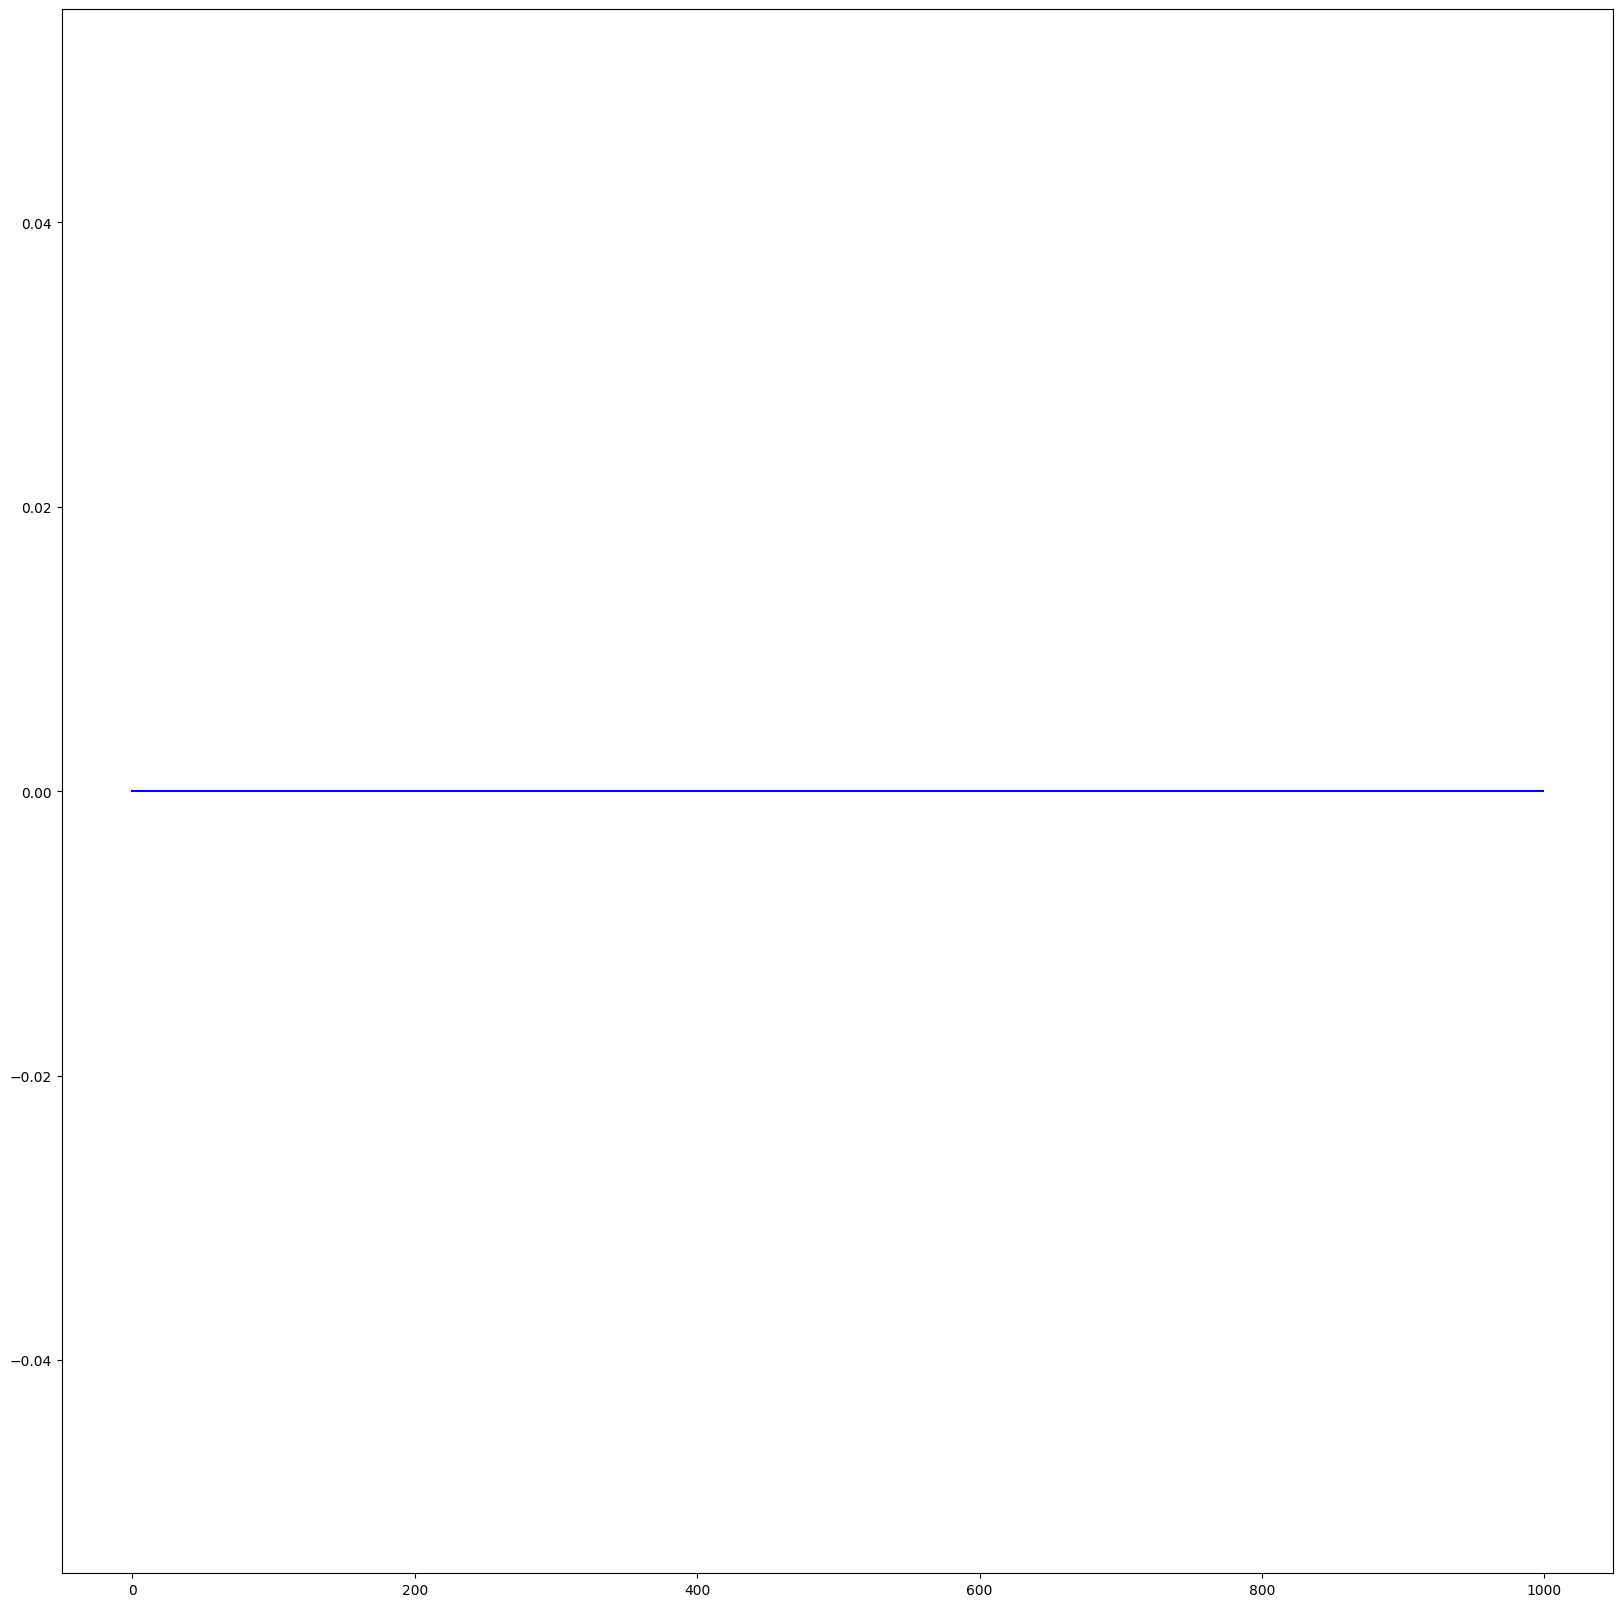

In [39]:
import matplotlib.pyplot as plt
freqx = []
freqy = []
for x, y in zip(xvalid, yvalid):
     if x[1] == ((300 -300)/ 400.0 ) and x[3] == ((70 - 50) / 90.0)  and x[0] == 1:
          freqx.append(x)
          freqy.append(y)

freqx = np.array(freqx)
freqy = np.array(freqy)

freqx = freqx[freqx[:, 2].argsort()]
freqy = freqy[freqx[ :, 2].argsort()]

ypred = model(torch.from_numpy(freqx))

plt.figure(figsize=(32, 48))
for c in range(1):
    plt.subplot(3, 2, c + 1)
    # plt.plot(range(1000), ypred.detach().numpy().flatten()[:], color="red")
    plt.plot(range(1000), freqy[:, 1], color="blue")

plt.tight_layout()
plt.show()  

In [20]:
# torch.save(model.state_dict(), r"/Users/suyashsachdeva/Desktop/Chaos/model_dict.pth")

(902, 4) (902, 2)
(902, 4) (902, 2)
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
    

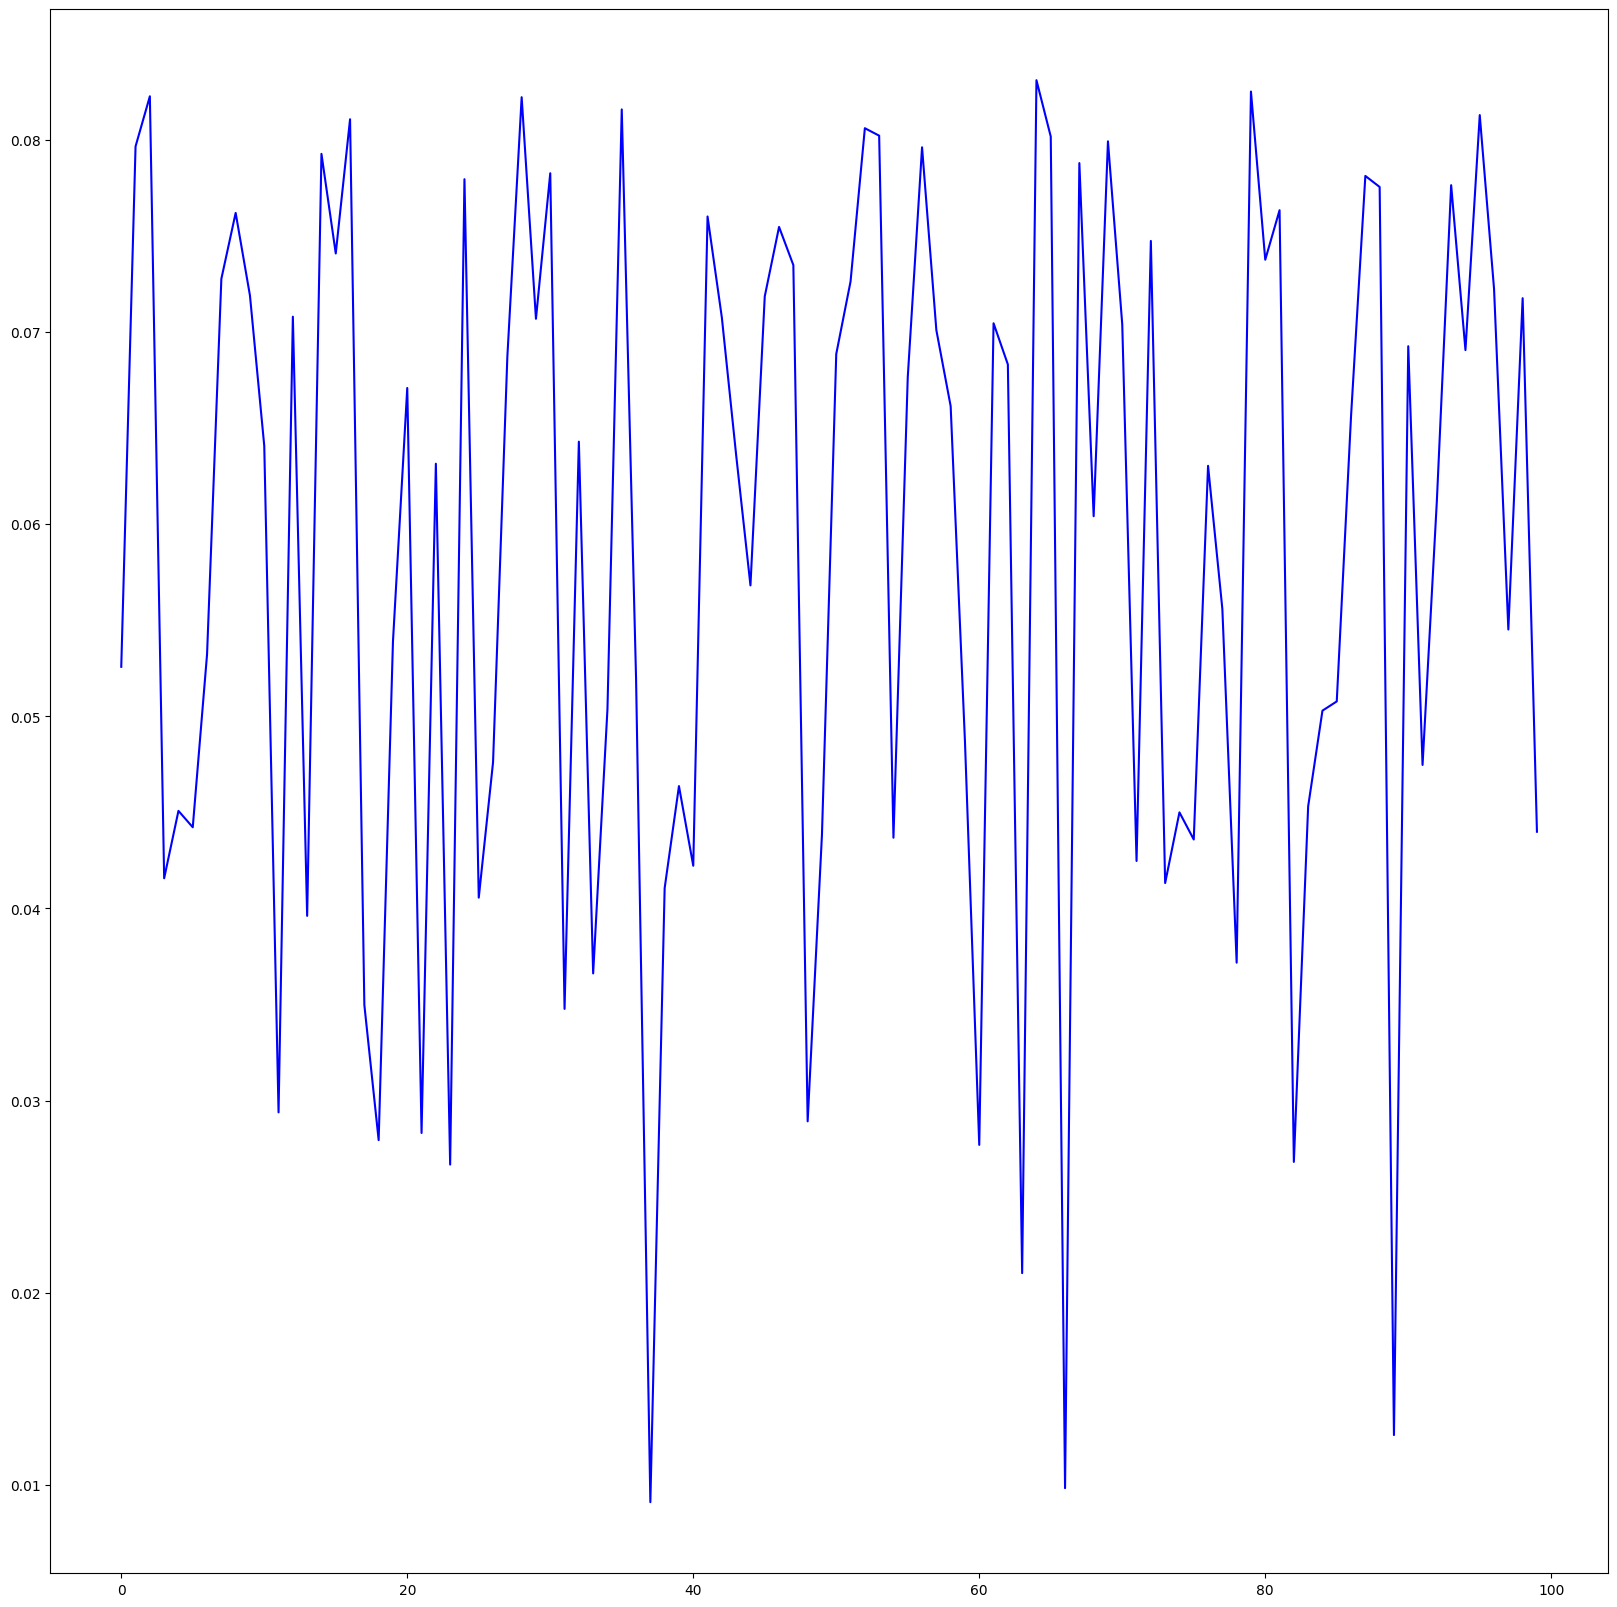

In [17]:
import matplotlib.pyplot as plt
freqx = []
freqy = []
for x, y in zip(xtrain, ytrain):
     if x[1] == ((600 -300)/ 400.0 ) and x[3] == ((130 - 50) / 90.0)  and x[0] == 1:
          freqx.append(x)
          freqy.append(y)

freqx = np.array(freqx)
freqy = np.array(freqy)


print(freqx.shape, freqy.shape)

freqx = freqx[freqx[:, 2].argsort()]
freqy = freqy[freqx[ :, 2].argsort()]
print(freqx.shape, freqy.shape)

ypred = model(torch.from_numpy(freqx))
print(ypred)

plt.figure(figsize=(32, 48))
for c in range(1):
    plt.subplot(3, 2, c + 1)
    plt.plot(range(100), ypred.detach().numpy().flatten()[:100], color="red")
    plt.plot(range(100), freqy[:100, 0], color="blue")

plt.tight_layout()
plt.show()   

In [38]:
freqy.shape

(1000, 2)

In [30]:
freqx

array([[1.        , 0.        , 0.        , 0.22222222],
       [1.        , 0.        , 0.001001  , 0.22222222],
       [1.        , 0.        , 0.002002  , 0.22222222],
       ...,
       [1.        , 0.        , 0.997998  , 0.22222222],
       [1.        , 0.        , 0.998999  , 0.22222222],
       [1.        , 0.        , 1.        , 0.22222222]], dtype=float32)